In [1]:
import equinox as eqx
import os 

# Foundational SSM imports
from foundational_ssm.utils import h5_to_dict, load_model_and_state_from_checkpoint_wandb
from foundational_ssm.transform import smooth_spikes
from foundational_ssm.plotting import aggregate_bin_label_results, plot_pred_vs_targets_by_angle_bin
import jax
import pandas as pd 

%load_ext autoreload
%autoreload 2

# Using model loaded from checkpoint

In [ ]:
layer = "2"
pretrain_mode = "scratch"
train_mode = "all"
alias = "best" # can be latest/best/ epoch_{any value in range(0,1000,100)}
# epoch 0 now stores a fresh model.
artifact_full_name = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:{alias}"
model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name)

# Download mc_rtt_trialized from https://huggingface.co/datasets/MelinaLaimon/nlb_processed/tree/main
# Edit dataset_dir to your directory
dataset_dir = "../../data/foundational_ssm/processed/nlb" 
trial_info = pd.read_csv(os.path.join(dataset_dir, "mc_rtt_trialized.csv"))
dataset_path = os.path.join(dataset_dir, "mc_rtt_trialized.h5")
data = h5_to_dict(dataset_path)
data["neural_input"] = smooth_spikes(data["neural_input"], kern_sd_ms=20, bin_size_ms=5, time_axis=1)
input = data["neural_input"]
target_vel = data["behavior_input"]

# Specify the layers you want to generate the activations of. 
# ["post_encoder", "ssm_pre_activation", "ssm_post_activation"]
layer_keys = ["ssm_pre_activation"] 
inf_model = eqx.nn.inference_mode(model) # Switches off dropout
pred_vel, _, activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, None))(input, state, layer_keys)

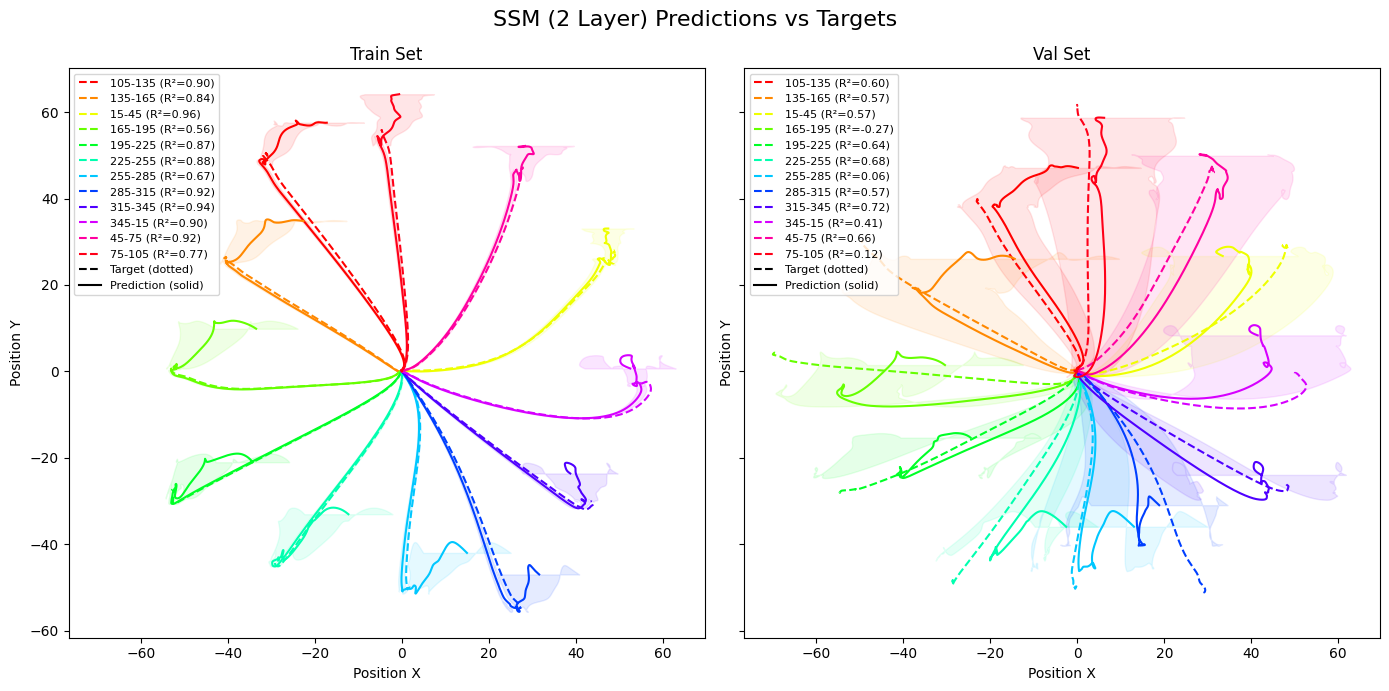

In [3]:
results_df = aggregate_bin_label_results(trial_info, target_vel, pred_vel)
fig = plot_pred_vs_targets_by_angle_bin(results_df, "SSM (2 Layer) Predictions vs Targets")
fig.show()